**激活函数的作用**
- 在模型的内部，它允许输出函数在不同的值上有不同的斜率，这是线性函数无法做到的。通过巧妙地为许多输出设置不同的斜率，神经网络可以近似任意函数
- 在网络的最后一层，它的作用是将前面的线性运算的输出集中到给定的范围内

**细说第二个作用**
1. 限制输出范围
2. 压缩输出范围

有相当多的激活函数，其中一些函数如图 6.5 所示。第 1 列中包含平滑函数 tanh 和 Softplus，而第 2 列左侧有激活函数的“硬”版本： Hardtanh 和 ReLU。 ReLU（用于整流线性单元）值得特别注意，因为它目前被认为是性能最好的通用激活函数之一，许多先进的结果都使用它出。Sigmoid 激活函数也被称为 logistic 函数，在早期的深度学习工作中被广泛使用，但现在已经不常用了。除非我们明确希望将输出规范到 0～1：例如，当输出应该是一个概率的时候。最后，LeakyReLU 函数修改了标准 ReLU，使其具有一个小的正斜率，而不是对于负输入严格地归零，通常这个斜率是 0.01，但为了使图像更清晰，这里显示的斜率为 0.1。

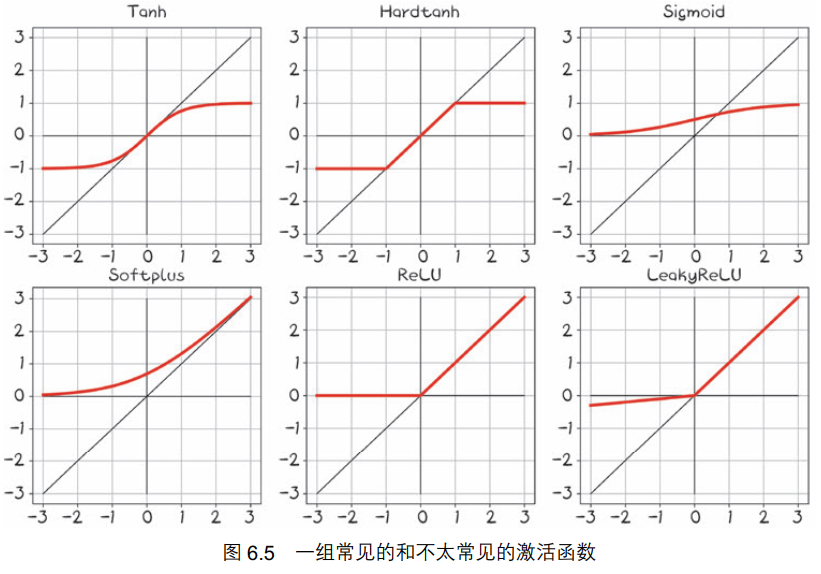

**激活函数有如下特性**
- 激活函数是非线性的。在没有激活函数的情况下，重复应用$(w*x+b)$ 会导致相同线性形式（仿射线性）的函数。非线性使得整个网络能够逼近更复杂的函数。
- 激活函数是可微的，因此可以通过它们计算梯度。正如我们在 Hardtanh 或 ReLU 中所看到的，点不连续性是很好的。没有这些特性，网络要么退回到线性模型，要么变得难以训练。

**以下是函数的真实情况**
- 它们至少有一个敏感范围，在这个范围内，对输入的变化会导致输出产生相应的变化，这是训练所需要的。
- 它们包含许多不敏感（或饱和）的范围， 即输入的变化导致输出的变化很小或没有变化。

举例来说，通过结合不同权重和输入偏置的敏感范围，可以很容易地使用 Hardtanh 对一个函数进行分段线性逼近。
通常情况下（但并非普遍如此），激活函数至少有以下一种特征。
- 当输入到负无穷大时，接近（或满足）一个下限。
- 正无穷时相似但上界相反。

In [38]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

In [39]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

t_u.shape

torch.Size([11, 1])

In [40]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 2,  1,  7,  6,  8, 10,  5,  3,  9]), tensor([4, 0]))

In [41]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [42]:
import torch.nn as nn
# 参数是输入张量的大小、输出张量的大小和默认为 True 的偏置
linear_model = nn.Linear(1,1)
linear_model(t_un_val)

tensor([[2.5197],
        [1.8276]], grad_fn=<AddmmBackward0>)

In [43]:
linear_model.weight

Parameter containing:
tensor([[0.3359]], requires_grad=True)

In [44]:
linear_model.bias

Parameter containing:
tensor([0.6284], requires_grad=True)

In [45]:
x = torch.ones(1)
linear_model(x)

tensor([0.9643], grad_fn=<AddBackward0>)

In [46]:
# 1. 批量输入
x = torch.ones(10,1)
linear_model(x)

tensor([[0.9643],
        [0.9643],
        [0.9643],
        [0.9643],
        [0.9643],
        [0.9643],
        [0.9643],
        [0.9643],
        [0.9643],
        [0.9643]], grad_fn=<AddmmBackward0>)

In [47]:
# 2. 优化批次
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

In [48]:
linear_model.parameters()

<generator object Module.parameters at 0x000001A7EBF7F820>

In [49]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.3359]], requires_grad=True),
 Parameter containing:
 tensor([0.6284], requires_grad=True)]

In [50]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                    f" Validation loss {loss_val.item():.4f}")

In [51]:
linear_model = nn.Linear(1,1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(n_epochs=3000,
              optimizer=optimizer,
              model=linear_model,
              loss_fn=nn.MSELoss(),
              t_u_train=t_un_train,
              t_u_val=t_un_val,
              t_c_train=t_c_train,
              t_c_val=t_c_val)

print()
print("weight: ",linear_model.weight)
print("bias: ", linear_model.bias)

Epoch 1, Training loss 313.5939, Validation loss 104.3237
Epoch 1000, Training loss 3.6037, Validation loss 7.2035
Epoch 2000, Training loss 2.8428, Validation loss 4.6554
Epoch 3000, Training loss 2.8207, Validation loss 4.3102

weight:  Parameter containing:
tensor([[5.2843]], requires_grad=True)
bias:  Parameter containing:
tensor([-16.4907], requires_grad=True)


In [53]:
seq_model = nn.Sequential(
    nn.Linear(1,13), # 随便指定输出张量的大小为 13
    nn.Tanh(),
    nn.Linear(13,1)) # 这里的张量形状大小值 13 必须与前一个模块输出张量的大小相等
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [54]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [55]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [56]:
from collections import OrderedDict
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8,1))
]))
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [57]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [58]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.0215], requires_grad=True)

In [59]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 216.6045, Validation loss 61.2152
Epoch 1000, Training loss 4.8346, Validation loss 3.7399
Epoch 2000, Training loss 3.1566, Validation loss 1.1275
Epoch 3000, Training loss 1.9532, Validation loss 2.1631
Epoch 4000, Training loss 1.7512, Validation loss 2.7375
Epoch 5000, Training loss 1.8359, Validation loss 2.5675
output tensor([[12.8012],
        [ 2.7380]], grad_fn=<AddmmBackward0>)
answer tensor([[11.0000],
        [ 0.5000]])
hidden tensor([[  2.0221],
        [-12.4063],
        [ -1.3872],
        [ 14.3387],
        [ -0.8283],
        [  1.1066],
        [ 14.4342],
        [  1.7833]])


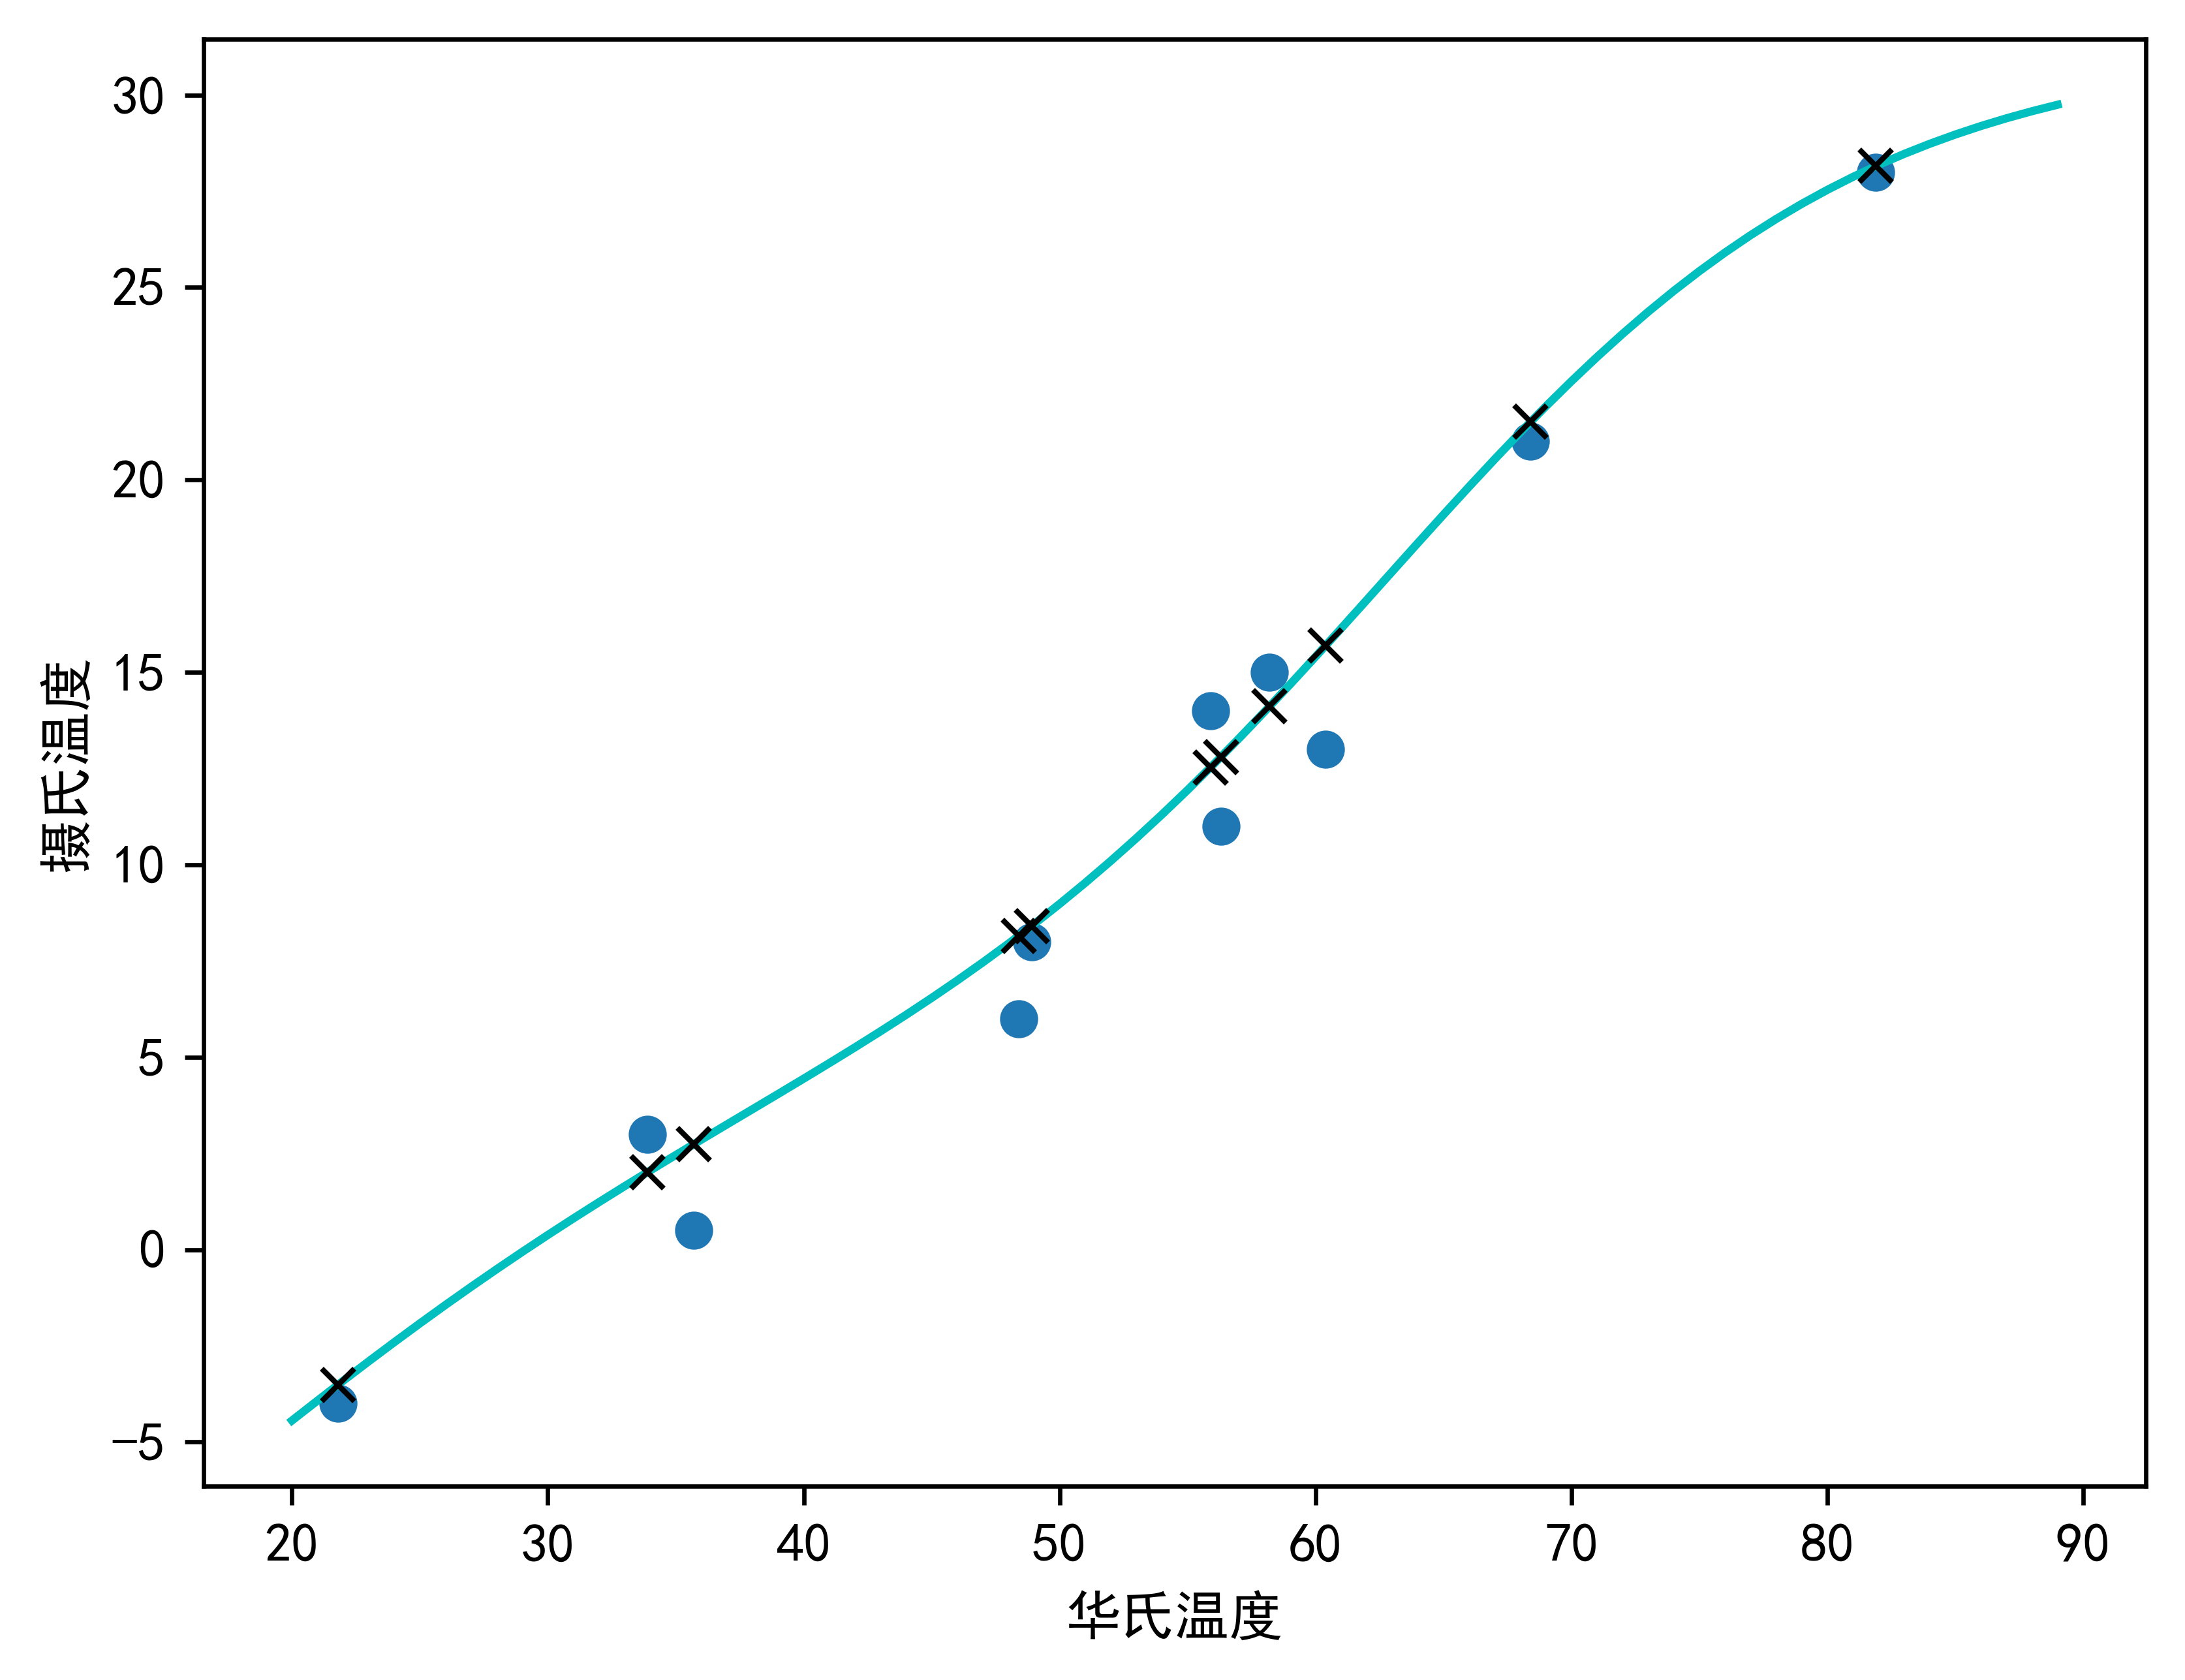

In [69]:
from matplotlib import pyplot as plt
plt.rcParams["font.sans-serif"]=["SimHei"]
plt.rcParams["axes.unicode_minus"]=False
t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("华氏温度")
plt.ylabel("摄氏温度")
plt.plot(t_u.numpy(), t_c.numpy(), 'o') # 圆点
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-') # 蓝色实线
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx') # 黑色叉形标记

输入数据（用圆圈表示）和模型输出（用 X 表示）。连续的线显示了样本之间的行为。